Let's generate N discrete time series, each consisting of T observations of a random variable X.

First, we load the necessary python packages.
                    

In [1]:
# Check python version
import sys
print("Python is:", sys.version)

# Import matplotlib and numpy
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib is:", matplotlib.__version__)

import numpy as np
print("numpy is:", np.__version__)

import random
from scipy.stats import norm
from scipy.stats import triang
from scipy.stats import t

%matplotlib inline

Python is: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Matplotlib is: 3.1.3
numpy is: 1.18.1


Next, we generate the series of random numbers. $N$ is the number of different series, and $T$ specifies how many observation we have in each series.

We also set the range of the distribution we will consider [x_min, x_max], and the number of bins, n_bins, into which we will split this range. 

In [2]:
N=1000
T=10

x_min=0
x_max=1
n_bins=10
bin_width=(x_max-x_min)/n_bins

# setup distribution as function "dist" so that later code is distribution-independent 

# normal distribution
# l = (x_max-x_min)/2 # location
# s = (x_max-x_min)/4 # scale
# dist = norm(loc=l, scale=s)

# t distribution
# df = 3 # shape
# l = (x_max-x_min)/2 # location
# s = (x_max-x_min)/4 # scale
# dist = t(df, loc=l, scale=s)

# triangular distribution
c = 0.5 # centre
l = x_min # location
s = x_max-x_min # scale
dist = triang(c, loc=l, scale=s)

# generate random variables
X=dist.rvs(size=[N,T]) # this avoids for loops

#X=np.zeros((N,T))
#for i in range(0,N):
#    for j in range(0,T):
#        X[i][j]=dist.rvs()

Next, we

1. Count observations in each bin, for each of the N time series, yielding N histograms.

2. Estimate the uncertainty in the bin counts as the standard deviation across all time series.

3. Construct the decision weight density $w$ by adding the uncertainty to each count, dividing by the total observations, and normalising.

4. Construct the CDF of the decision weights.

5. Find the CDF of the reference distribution we used to generate the data.

In [3]:
#1 count
n=np.empty((N,n_bins))

for series in range(0,N):
    n[series][:]=np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[0]
    
x_bins=np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[1] # bin edges

x_l=x_bins[0:-1]
x_r=x_bins[1:]
x_bin_c=(x_l+x_r)/2

In [4]:
#2 find DM's count, mean count, and uncertainty
dm_count=n[0] # DM's count
mean_count=np.mean(n,0)# sample mean count across DMs
uncertainty=np.std(n,0) # uncertainty in count
count=mean_count # decide which count to use

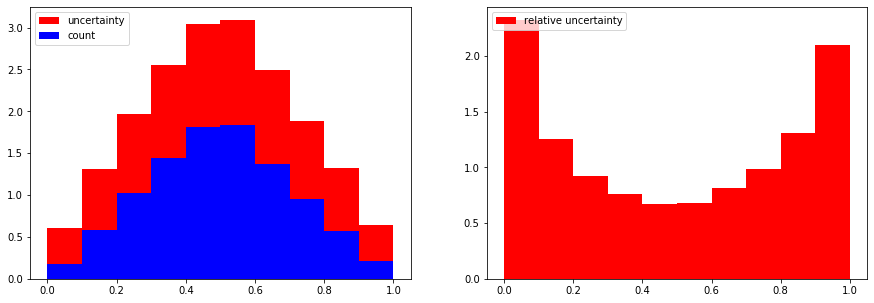

In [5]:
#fig=plt.figure()
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
#ax=fig.add_axes([0,0,1,1])
axes[0].hist(x_bins[:-1], x_bins, weights=count+uncertainty,color='r',label='uncertainty')
axes[0].hist(x_bins[:-1], x_bins, weights=count,color='b',label='count')
axes[0].legend(loc=2)
axes[1].hist(x_bins[:-1], x_bins, weights=uncertainty/count,color='r',label='relative uncertainty')
axes[1].legend(loc=2)

plt.show()

In [6]:
#3 construct decision weights and normalize
phat=count/(T*bin_width) # estimated (mean) density
wraw=phat+uncertainty/(T*bin_width) # unnormalised decision weight
wmass=np.sum(wraw)*bin_width # unnormalised mass
w=wraw/wmass # normalised decision weight density

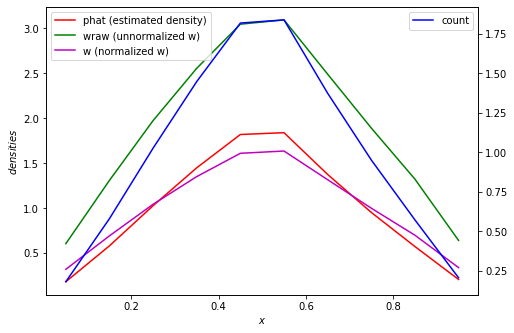

In [7]:
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])
ax1.plot(x_bin_c,phat,'r',label='phat (estimated density)')
ax1.plot(x_bin_c,wraw,'g',label='wraw (unnormalized w)')
ax1.plot(x_bin_c,w,'m',label='w (normalized w)')
ax1.legend(loc=2)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$densities$')
ax2 = ax1.twinx()
ax2.plot(x_bin_c,count,'b',label='count')
ax2.legend(loc=1)

plt.show() 

In [8]:
#4 find decision weight CDF
Fw=np.cumsum(w)*bin_width
Fw

array([0.03197878, 0.10115661, 0.20543722, 0.34045066, 0.50136122,
       0.66479749, 0.7963473 , 0.89625413, 0.96612733, 1.        ])

In [9]:
#5 find reference CDF
#x_bins=np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[1] # bin edges
#x_bins=x_bins[1:] # remove first bin edge
#Fp=triang.cdf(np.histogram(X[series][:],bins=n_bins,range=(x_min,x_max))[1],.5,0,1)
#Fp=norm.cdf(x_r,0,1)
#Fp=triang.cdf(x_r,.5,0,1)

# generic distribution
Fp=dist.cdf(x_r)
Fp

array([0.02, 0.08, 0.18, 0.32, 0.5 , 0.68, 0.82, 0.92, 0.98, 1.  ])

Finally, we display the resulting ``probability weighting,'' in the usual way and recover the inverse-S curve... or do we?

No handles with labels found to put in legend.


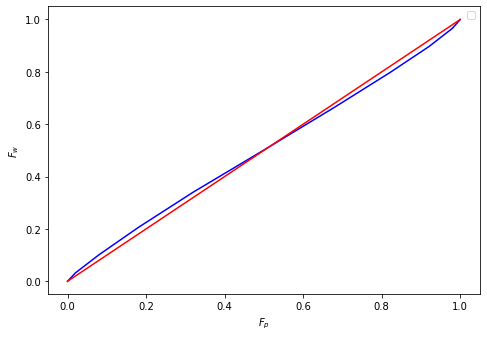

In [10]:
Fp=np.concatenate(([0],Fp)) # add known x->infinity limits
Fw=np.concatenate(([0],Fw))
Fp=np.concatenate((Fp,[1])) # add known x->infinity limits
Fw=np.concatenate((Fw,[1]))

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(Fp,Fw,'b',label='')
ax.plot(Fp,Fp,'r',label='')
ax.legend()
ax.set_xlabel(r'$F_p$')
ax.set_ylabel(r'$F_w$')
plt.show() 